# Object Localization

In [1]:
import pandas as pd
import numpy 
import cv2
import matplotlib.pyplot as plt
import torch
from torch import nn
import albumentations as A # library for data augmentation
from torchvision import transforms as T

# Albumentations is better than transformer from torchvision
import sys
import os

import timm

from tqdm.notebook import tqdm # provides progress bar widget  'Progress'

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder # used to encode categorical labels into numerical values

In [2]:
sys.path.append('./object-localization-dataset/')

## Config

In [3]:
CSV_FILE = './object-localization-dataset/train.csv'
DATA_DIR = './object-localization-dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4 # number of coordinates

In [4]:
df = pd.read_csv(CSV_FILE)
df.head()

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant


### Dataset

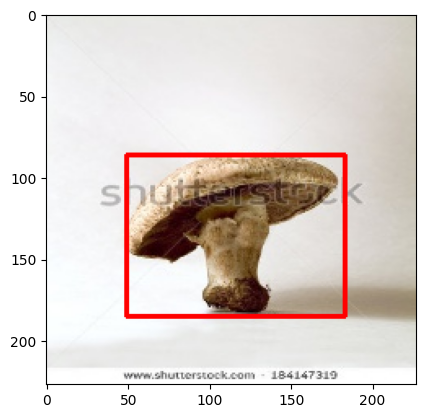

In [5]:
row = df.iloc[2]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img, pt1, pt2, (255, 0, 0), thickness=2)
plt.imshow(bnd_box_img)

In [6]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

## Preprocessing  -  Augmentations

In [7]:
train_augs = A.Compose(
    [
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate()
    ],bbox_params=A.BboxParams(format='pascal_voc' ,label_fields = ['class_labels'])
)

valid_augs = A.Compose(
    [
        A.Resize(IMG_SIZE, IMG_SIZE),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'])
)

### Create Custom Dataset

In [8]:
class ObjLocDataset(torch.utils.data.Dataset):
    def __init__(self, df, augmentation):
        self.df = df
        self.augmentations = augmentation
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        row = self.df.iloc[idx]
        xmin = row.xmin
        ymin = row.ymin
        xmax = row.xmax
        ymax = row.ymax
        
        bbox = [[xmin, ymin, xmax, ymax]] # list in list, the augmentations take input in this format
        
        img_path = DATA_DIR + row.img_path
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.augmentations:
            data = self.augmentations(image=img, bboxes=bbox, class_labels=[None])
            img = data['image'] 
            bbox = data['bboxes'][0]  # to get the list

        img = torch.from_numpy(img).permute(2, 0, 1) / 250
        bbox = torch.Tensor(bbox)
        
        return img, bbox

In [9]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, valid_augs)

In [10]:
print(f"Total examples in the training set: {len(trainset)}")
print(f"Total examples in the testing set: {len(validset)}")

Total examples in the training set: 148
Total examples in the testing set: 38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


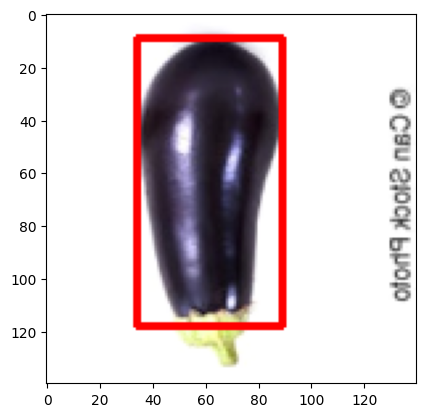

In [11]:
idx = 1

img, bbox = trainset[idx]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img=img.permute(1, 2, 0).numpy(), pt1=pt1, pt2=pt2, color=(255, 0, 0), thickness=2)
plt.imshow(bnd_img)

## Load Dataset into Batches

In [12]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
print("Total no of batches in trainloader: {}".format(len(trainloader)))
print(f"Total no of batches in validloader: {len(validloader)}")

Total no of batches in trainloader: 10
Total no of batches in validloader: 3


In [14]:
for images, bboxes in trainloader:
    break;
print(f"Shape of one batch images: {images.shape}") # batch size, channels, height, width
print(f"Shape of one batch bboxes: {bboxes.shape}") # batch_size, 4 values (xmin, ymin, xmax, ymax)


Shape of one batch images: torch.Size([16, 3, 140, 140])
Shape of one batch bboxes: torch.Size([16, 4])


## Create Model

In [15]:
class ObjLocModel(nn.Module):
    def __init__(self):
        super(ObjLocModel, self).__init__()  # Corrected class name here
        # timm outputs only logits without the activation in the output layer
        self.backbone =  timm.create_model(model_name=MODEL_NAME, pretrained=True, num_classes=4)
        
    def forward(self, images, gt_bboxes=None):  # images, ground_truth_bounding_boxes - only for training 
        bboxes = self.backbone(images)
        
        if gt_bboxes is not None:
            loss = nn.MSELoss()(bboxes, gt_bboxes)
            return bboxes, loss
        return bboxes

In [16]:
model = ObjLocModel()
model.to(device=DEVICE)

ObjLocModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(

In [17]:
random_img = torch.rand(1, 3, 140, 140).to(DEVICE)
model(random_img).shape


torch.Size([1, 4])

## Create Train and Eval Function

In [22]:
def train_fn(model, dataloader, optimizer):
    train_loss = 0
    model.train()  # Dropout layer should be ON 
    
    for data in tqdm(dataloader): # tqdm to consider the batches
        images, gt_bboxes = data # unpack the data 
        images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
        
        bboxes, loss = model(images, gt_bboxes)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item() # every batch loss
    
    return train_loss / len(dataloader) # dividing by batchsize
    

In [24]:
def eval_fn(model, dataloader):
    eval_loss = 0
    model.eval()  # Dropout layer should be ON 
    
    with torch.no_grad():
        for data in tqdm(dataloader): # tqdm to consider the batches
            images, gt_bboxes = data # unpack the data 
            images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
            
            bboxes, loss = model(images, gt_bboxes)
                            
            eval_loss += loss.item() # every batch loss
        
        return eval_loss / len(dataloader) # dividing by batchsize
        

## Training Loop

In [20]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

In [25]:
best_valid_loss = numpy.Inf

for i in range(EPOCHS):
    train_loss = train_fn(model, trainloader, optimizer)
    valid_loss = eval_fn(model, validloader)
    
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'model_40EPOCHS.pt')
        print("Weights are saved!!")
        best_valid_loss = valid_loss
        
    print(f"Epoch: {i+1} Train loss: {train_loss} Valid loss: {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!!
Epoch: 1 Train loss: 1876.213818359375 Valid loss: 1060.0499471028645


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!!
Epoch: 2 Train loss: 1020.8843200683593 Valid loss: 238.0660858154297


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!!
Epoch: 3 Train loss: 713.5414916992188 Valid loss: 204.80585734049478


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!!
Epoch: 4 Train loss: 508.56580810546876 Valid loss: 135.04486083984375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 5 Train loss: 418.1242309570313 Valid loss: 165.5606231689453


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 6 Train loss: 275.6401840209961 Valid loss: 209.4570515950521


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 7 Train loss: 202.85318908691406 Valid loss: 158.4365030924479


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 8 Train loss: 192.77137451171876 Valid loss: 146.57966105143228


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!!
Epoch: 9 Train loss: 142.5343101501465 Valid loss: 124.84328969319661


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!!
Epoch: 10 Train loss: 109.43145294189453 Valid loss: 110.14305114746094


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 11 Train loss: 116.02940711975097 Valid loss: 148.63012186686197


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 12 Train loss: 89.25340919494629 Valid loss: 134.7353312174479


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 13 Train loss: 103.1042652130127 Valid loss: 114.50121561686198


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!!
Epoch: 14 Train loss: 92.10012931823731 Valid loss: 82.79209772745769


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 15 Train loss: 87.23108444213867 Valid loss: 86.9116808573405


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 16 Train loss: 90.20560989379882 Valid loss: 99.79003143310547


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!!
Epoch: 17 Train loss: 78.16233825683594 Valid loss: 78.92351404825847


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 18 Train loss: 67.50536079406739 Valid loss: 84.44907887776692


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 19 Train loss: 66.18993263244629 Valid loss: 88.06049346923828


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 20 Train loss: 78.68145637512207 Valid loss: 102.45639038085938


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!!
Epoch: 21 Train loss: 57.79869480133057 Valid loss: 78.56850306193034


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!!
Epoch: 22 Train loss: 57.13087425231934 Valid loss: 62.38144175211588


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 23 Train loss: 58.60353584289551 Valid loss: 71.17292022705078


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 24 Train loss: 75.08075408935547 Valid loss: 75.0807113647461


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 25 Train loss: 63.59233932495117 Valid loss: 70.16455841064453


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 26 Train loss: 48.88955211639404 Valid loss: 81.78721618652344


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!!
Epoch: 27 Train loss: 58.327653884887695 Valid loss: 60.41768137613932


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved!!
Epoch: 28 Train loss: 53.96771011352539 Valid loss: 52.47141710917155


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 29 Train loss: 44.93869953155517 Valid loss: 78.81837463378906


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30 Train loss: 51.32090835571289 Valid loss: 62.957532246907554


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 31 Train loss: 48.766879081726074 Valid loss: 54.21104939778646


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 32 Train loss: 43.954336929321286 Valid loss: 68.9939193725586


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 33 Train loss: 38.29808712005615 Valid loss: 54.94512939453125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 34 Train loss: 39.82728099822998 Valid loss: 67.93226114908855


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 35 Train loss: 41.5839921951294 Valid loss: 64.36609522501628


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 36 Train loss: 39.616420364379884 Valid loss: 72.61687342325847


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 37 Train loss: 43.78396987915039 Valid loss: 53.33716710408529


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 38 Train loss: 36.09804153442383 Valid loss: 61.14101918538412


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 39 Train loss: 45.828497123718265 Valid loss: 54.20171991984049


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 40 Train loss: 45.985330200195314 Valid loss: 66.88327280680339


In [49]:
model.load_state_dict(torch.load('model_40EPOCHS.pt'))
model.eval()

with torch.no_grad():
    image, gt_bbox = validset[1]
    image = image.unsqueeze(0).to(DEVICE)
    out_bbox = model(image)

out_bbox

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
